# 목차
## 1. Library Import
## 2. 학습데이터 생성
## 3. Light-gbm 모델 훈련
## 4. 교차 검증 점수 확인
## 5. 제출 파일 생성

## 1. Library Import

In [1]:
import pandas as pd
import numpy as np

import datetime as dt

import matplotlib.pyplot as plt

from tqdm import tqdm

import gc
import random
import lightgbm as lgb
import re

from sklearn.metrics import *
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings(action='ignore')

# 모듈
import os, pathlib, glob
import random
from pytz import timezone # Colab 사용 시, Asia/Seoul로 지정 필요

from pycaret.classification import *

In [2]:
!pip install pycaret

     |████████████████████████████████| 256kB 11.7MB/s 
     |████████████████████████████████| 245kB 12.1MB/s 
     |████████████████████████████████| 65.8MB 50kB/s 
     |████████████████████████████████| 157.5MB 86kB/s 
     |████████████████████████████████| 1.6MB 49.3MB/s 
     |████████████████████████████████| 276kB 49.5MB/s 
     |████████████████████████████████| 102kB 7.8MB/s 
     |████████████████████████████████| 174kB 51.9MB/s 
     |████████████████████████████████| 14.2MB 364kB/s 
     |████████████████████████████████| 1.8MB 38.7MB/s 
     |████████████████████████████████| 6.8MB 32.4MB/s 
     |████████████████████████████████| 81kB 7.1MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 3.1MB 46.0MB/s 
     |████████████████████████████████| 604kB 48.6MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 2.1MB 30.4MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
  

In [2]:
# HDLY
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# HDLY
# 작업경로 변경
os.chdir('/content/gdrive/MyDrive/Colab/Dacon_LG_AUC')

print('Current directory: ', os.getcwd())

Current directory:  /content/gdrive/MyDrive/Colab/Dacon_LG_AUC


In [4]:
# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)



def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)



def days2d(x):
    # days의 값으로 요일 만들기
    # 2020년 11월 1일은 일요일
    day_list = ['SAT', 'SUN', 'MON', 'TUE', 'WED', 'THU', 'FRI']
    return day_list[x % 7]



def fwver2int(x):
    # firmware version을 8자리의 포맷을 갖는 int 값으로 변환해서 변수로 사용해보기    
    num_dot = x.count(".")
    x = x.split(".")
    # x = map(int, x.split("."))

    fw_ctgr = x[0] .zfill(2)

    if num_dot == 2 :
      x = int(x[0])*1000000 + int(x[1])*10000 + int(x[2])
    elif num_dot == 1 : 
      x = int(x[0])*1000000 + int(x[1])*10000
    else : 
      x = int(x[0])*1000000
    
    return fw_ctgr + str(x)

In [ ]:
# # HDLY_0127
# # firmware_version data에 대한 EDA

# # train_err 안에 있는 fwver unique 값으로 확인
# tmp_fwver = [
#              '8.5.3', '10', '05.15.2138', '04.33.1185', '04.33.1261', '04.22.1750',
#              '04.22.1778', '04.16.3553', '04.33.1149', '04.16.3571',
#              '05.66.3237', '05.66.3571', '03.11.1149', '04.22.1684',
#              '03.11.1167', '04.82.1684', '04.82.1778', '04.33.1171',
#              '04.73.2237', '10', '04.82.1730', '04.73.2571', '8.5.3',
#              '04.22.1666', '03.11.1141', '05.15.2120', '04.33.1125',
#              '04.16.3439', '04.22.1442', '04.33.1095', '04.16.3569',
#              '05.15.2090', '05.15.3104', '05.15.2122', '04.22.1656',
#              '04.16.2641', '05.15.2114', '04.16.3345', '05.15.2092'
#              ]

# tmp_fwver = pd.DataFrame({"fwver" : tmp_fwver})
# tmp_fwver.head()

,fwver
0,8.5.3
1,10
2,05.15.2138
3,04.33.1185
4,04.33.1261


In [ ]:
# # HDLY_0127
# # firmware_version data에 대한 EDA _ cont.

# # int로 변형 후 데이터 업데이트
# tmp_fwver.fwver = tmp_fwver.fwver.apply(fwver2int) # fwver -> int

# tmp_fwver['fw_ctgr'] = tmp_fwver.fwver.apply(lambda x : int(str(x)[0:2]))
# tmp_fwver['fwver'] = tmp_fwver.fwver.apply(lambda x : int(str(x)[2:]))

# tmp_fwver.head()

,fwver,fw_ctgr
0,8050003,8
1,10000000,10
2,5152138,5
3,4331185,4
4,4331261,4


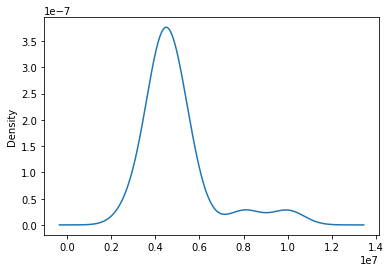

In [ ]:
# # HDLY_0127
# # firmware_version data에 대한 EDA _ cont.

# # firmware 값의 분포에 대한 시각화
# tmp_fwver.fwver.plot(kind='kde')

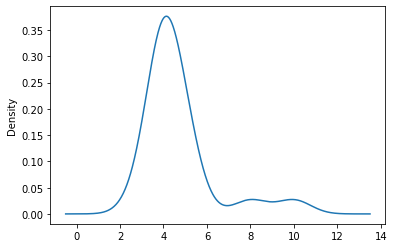

In [ ]:
# # HDLY_0127
# # firmware_version data에 대한 EDA _ cont.

# # firmware category 분포에 대한 시각화
# tmp_fwver.fw_ctgr.plot(kind='kde')

## 2. 학습데이터 생성

#### 2.1. train_err

* train_err_data.csv 파일의 errtype column의 value_counts를 카운트하여 학습에 사용.
* 주어진 기간동안 user_id별로 peroblem가 한 번이라도 발생했는 지를 확인.

In [5]:
PATH = os.getcwd() + '/'

train_err = pd.read_csv(PATH+'train_err_data.csv')
train_err.head()

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [6]:
# HDLY_0127
# firmware_version data에 대한 EDA _ cont.

# 이제 train_err data에 적용

train_err = pd.read_csv(PATH+'train_err_data.csv') # 1) load data

train_err.fwver = train_err.fwver.apply(fwver2int) # 2) convert fwver type : object -> int

train_err['fw_ctgr'] = train_err.fwver.apply(lambda x : int(str(x)[0:2])) # 3-1) get firmware categoty
train_err['fwver'] = train_err.fwver.apply(lambda x : int(str(x)[2:])) # 3-2) update the fwver values

# tmp_f_c = pd.get_dummies(train_err['fw_ctgr']) # 4) get firmware category
# tmp_f_c = tmp_f_c.rename(columns={3:'fw_ctgr_3', 4:'fw_ctgr_4', 5:'fw_ctgr_5', 8:'fw_ctgr_8', 10:'fw_ctgr10'})

# train_err = train_err.drop(columns=['fw_ctgr'])
# train_err = pd.concat([train_err, tmp_f_c], axis=1)

train_err # 5) check data

,user_id,time,model_nm,fwver,errtype,errcode,fw_ctgr
0,10000,20201101025616,model_3,5152138,15,1,5
1,10000,20201101030309,model_3,5152138,12,1,5
2,10000,20201101030309,model_3,5152138,11,1,5
3,10000,20201101050514,model_3,5152138,16,1,5
4,10000,20201101050515,model_3,5152138,4,0,5
...,...,...,...,...,...,...,...
16554658,24999,20201130163051,model_3,5152138,15,1,5
16554659,24999,20201130172625,model_3,5152138,16,1,5
16554660,24999,20201130172625,model_3,5152138,4,0,5
16554661,24999,20201130172631,model_3,5152138,4,0,5


In [ ]:
# tmp_f_c = pd.get_dummies(train_err['fw_ctgr'])

# tmp_f_c = tmp_f_c.rename(columns={3:'fw_ctgr_3', 4:'fw_ctgr_4', 5:'fw_ctgr_5', 8:'fw_ctgr_8', 10:'fw_ctgr10'})
# tmp_f_c

In [ ]:
# # HDLY_0127

# # train_err 저장
# train_err = train_err.drop(['user_id', 'time', 'model_nm', 'errtype', 'errcode'], axis=1)
# train_err.to_csv(PATH+'train_err_hdly0127ver.csv')

In [7]:
# HDLY_0127
# Test Data에도 firmware version 작업 수행

test_err = pd.read_csv(PATH+'test_err_data.csv') # 1) load data

test_err.fwver = test_err.fwver.apply(fwver2int) # 2) convert fwver type : object -> int

test_err['fw_ctgr'] = test_err.fwver.apply(lambda x : int(str(x)[0:2])) # 3-1) get firmware categoty
test_err['fwver'] = test_err.fwver.apply(lambda x : int(str(x)[2:])) # 3-2) update the fwver values

# test_err = test_err.drop(['user_id', 'time', 'model_nm', 'errtype', 'errcode'], axis=1)
# test_err.to_csv(PATH+'test_err_hdly0127ver.csv') # 4) # test_err 저장

# tmp_f_c_2 = pd.get_dummies(test_err['fw_ctgr']) # 4) get firmware category
# tmp_f_c_2 = tmp_f_c_2.rename(columns={3:'fw_ctgr_3', 4:'fw_ctgr_4', 5:'fw_ctgr_5', 8:'fw_ctgr_8', 10:'fw_ctgr10'})

# test_err = test_err.drop(columns=['fw_ctgr'])
# test_err = pd.concat([test_err, tmp_f_c_2], axis=1)

test_err # 5) check data

,user_id,time,model_nm,fwver,errtype,errcode,fw_ctgr
0,30000,20201101030227,model_1,4163553,31,1,4
1,30000,20201101030227,model_1,4163553,33,2,4
2,30000,20201101030228,model_1,4163553,15,1,4
3,30000,20201101030256,model_1,4163553,22,1,4
4,30000,20201101030300,model_1,4163553,11,1,4
...,...,...,...,...,...,...,...
16532643,44998,20201130210050,model_1,4163553,40,0,4
16532644,44998,20201130211831,model_1,4163553,31,1,4
16532645,44998,20201130211832,model_1,4163553,15,1,4
16532646,44998,20201130212259,model_1,4163553,16,1,4


In [ ]:
#  train_err['fw_ctgr'].unique()

array([ 5,  4,  3, 10,  8])

In [8]:
# HDLY_0127
#  train_err의 fw_ctgr 값을 id 기분으로 count

train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

id_fw_ctgr = train_err[['user_id', 'fw_ctgr']].values
fw_ctgr_list = np.zeros((train_user_number, 10))

for person_idx, f_c_l  in tqdm(id_fw_ctgr):
    fw_ctgr_list[person_idx - train_user_id_min , f_c_l -1 ] += 1

100%|██████████| 16554663/16554663 [01:09<00:00, 238866.09it/s]


In [ ]:
########################################
########################################
########################################

In [9]:
# HDLY_0127
# train & test DataFrame 만들기

# train
data_mh_train = pd.read_csv(PATH+"0127_KMH_train_data_merge.csv") # load
drop_columns = data_mh_train.iloc[:, 51:98].columns[1:] # fwver 값들 삭제
data_mh_train = data_mh_train.drop(columns=drop_columns, axis=1)


# test
data_mh_test = pd.read_csv(PATH+"0127_KMH_test_data_merge_2.csv")
drop_columns = data_mh_test.iloc[:, 51:98].columns[1:] # fwver 값들 삭제
data_mh_test = data_mh_test.drop(columns=drop_columns, axis=1)

In [ ]:
# data_mh_train.sample(10)

,err0,err1,err2,err3,err4,err5,err6,err7,err8,err9,err10,err11,err12,err13,err14,err15,err16,err17,err18,err19,err20,err21,err22,err23,err24,err25,err26,err27,err28,err29,err30,err31,err32,err33,err34,err35,err36,err37,err38,err39,err40,err41,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,user_id,qual_0,qual_1,qual_2,qual_3,qual_4,qual_5,qual_6,qual_7,qual_8,qual_9,qual_10,qual_11,qual_12,problem
5559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,16.0,0.0,3.0,117.0,73.0,0.0,0.0,0.0,0.0,0.0,64.0,42.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,142.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,67.0,28.0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,15559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10569,0.0,0.0,0.0,1.0,53.0,0.0,0.0,0.0,0.0,0.0,19.0,19.0,0.0,0.0,176.0,148.0,1.0,0.0,0.0,0.0,0.0,82.0,52.0,1.0,0.0,47.0,0.0,0.0,0.0,0.0,224.0,0.0,19.0,0.0,0.0,1.0,1.0,0.0,0.0,18.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10720,0.0,0.0,0.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,42.0,43.0,6.0,1.0,83.0,84.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,117.0,572.0,42.0,0.0,0.0,0.0,0.0,4.0,0.0,58.0,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20720,0.0,1.0,0.0,0.0,0.0,0.0,32.0,384.0,12.0,0.0,0.0,0.0,0.0,0.0
9075,0.0,0.0,0.0,0.0,1.0,4.0,5.0,0.0,0.0,0.0,16.0,19.0,3.0,9.0,213.0,164.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,331.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,312.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7082,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,15.0,18.0,3.0,6.0,153.0,109.0,0.0,0.0,0.0,0.0,0.0,53.0,33.0,1.0,0.0,37.0,0.0,0.0,0.0,0.0,239.0,0.0,15.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10897,0.0,0.0,0.0,1.0,13.0,0.0,0.0,0.0,0.0,0.0,16.0,16.0,0.0,0.0,201.0,176.0,11.0,0.0,0.0,0.0,0.0,2181.0,2855.0,67.0,0.0,43.0,0.0,0.0,0.0,0.0,348.0,1147.0,16.0,8.0,0.0,2.0,2.0,0.0,0.0,98.0,40.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3089,0.0,4.0,0.0,1.0,45.0,0.0,1.0,0.0,0.0,0.0,13.0,13.0,0.0,0.0,115.0,71.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,0.0,0.0,38.0,0.0,0.0,0.0,0.0,86.0,0.0,13.0,0.0,0.0,1.0,1.0,0.0,0.0,16.0,42.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1046,0.0,0.0,3.0,15.0,3.0,3.0,3.0,0.0,0.0,0.0,15.0,18.0,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1619,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,0.0,0.0,183.0,142.0,1.0,0.0,0.0,0.0,0.0,22.0,11.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,261.0,0.0,15.0,5.0,0.0,0.0,0.0,0.0,8.0,116.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13985,0.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,36.0,36.0,0.0,1.0,67.0,106.0,3.0,1.0,0.0,1.0,0.0,215.0,189.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,193.0,0.0,40.0,10.0,0.0,1.0,1.0,1.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23985,0.0,0.0,0.0,0.0,0.0,10078.0,0.0,0.0,0.0,0.0,120936.0,0.0,0.0,1.0


In [ ]:
# data_mh_test.sample(10)

,err0,err1,err2,err3,err4,err5,err6,err7,err8,err9,err10,err11,err12,err13,err14,err15,err16,err17,err18,err19,err20,err21,err22,err23,err24,err25,err26,err27,err28,err29,err30,err31,err32,err33,err34,err35,err36,err37,err38,err39,err40,err41,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,03.11.1141,qual_1,qual_2,qual_3,qual_4,qual_5,qual_6,qual_7,qual_8,qual_9,qual_10,qual_11,qual_12
11562,0.0,0.0,0.0,0.0,14.0,2.0,3.0,0.0,0.0,49.0,62.0,66.0,2.0,58.0,240.0,202.0,1.0,0.0,0.0,0.0,0.0,26.0,10.0,2.0,0.0,43.0,0.0,0.0,0.0,0.0,359.0,0.0,13.0,0.0,0.0,1.0,1.0,0.0,0.0,24.0,0.0,1.0,1179.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,-64.0,0.0,0.0,3171.0,-64.0,0.0,0.0,0.0,37284.0,-64.0,0.0
12717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,0.0,0.0,77.0,40.0,0.0,0.0,0.0,0.0,0.0,24.0,8.0,3.0,0.0,48.0,0.0,0.0,0.0,0.0,79.0,0.0,13.0,0.0,0.0,1.0,1.0,0.0,0.0,171.0,2.0,6.0,0.0,0.0,499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,17.0,0.0,0.0,172.0,125.0,0.0,2.0,0.0,2.0,0.0,234.0,249.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,216.0,0.0,17.0,0.0,0.0,1.0,1.0,0.0,0.0,44.0,0.0,2.0,1148.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8268,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,0.0,0.0,47.0,8.0,0.0,0.0,0.0,0.0,0.0,30.0,9.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,25.0,0.0,15.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,9.0,0.0,0.0,202.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4059,0.0,0.0,0.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,52.0,52.0,0.0,0.0,12.0,39.0,1.0,0.0,0.0,0.0,0.0,72.0,2.0,0.0,0.0,72.0,0.0,0.0,0.0,0.0,70.0,0.0,52.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,467.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7815,0.0,0.0,0.0,0.0,4.0,4.0,3.0,0.0,0.0,0.0,17.0,21.0,2.0,5.0,82.0,39.0,1.0,0.0,0.0,0.0,0.0,29.0,9.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0,107.0,0.0,17.0,0.0,3.0,1.0,1.0,0.0,0.0,17.0,20.0,8.0,0.0,0.0,441.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,0.0,1.0,96.0,48.0,0.0,0.0,0.0,0.0,0.0,68.0,27.0,0.0,0.0,57.0,0.0,0.0,0.0,0.0,79.0,0.0,15.0,6.0,0.0,1.0,1.0,0.0,0.0,72.0,3.0,12.0,519.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6049,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,5.0,5.0,0.0,3.0,58.0,45.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,106.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,260.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13963,0.0,0.0,0.0,106.0,2.0,0.0,0.0,0.0,0.0,0.0,16.0,16.0,0.0,0.0,28.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
########################################
########################################
########################################

In [10]:
# HDLY_0127
# 데이터 병합 : train

tmp_df = pd.DataFrame(fw_ctgr_list.tolist()).add_prefix('fw_ctgr_')
df = tmp_df.join(data_mh_train)

# 0~9 중에서 (2, 3, 4, 7, 9)만 값이 있으니까 나머지는 drop
df = df.drop(columns=['fw_ctgr_0', 'fw_ctgr_1', 'fw_ctgr_5', 'fw_ctgr_6', 'fw_ctgr_8', ])

# 원래 번호로 이름 수정
df = df.rename(columns={'fw_ctgr_2':'fw_ctgr_3', 'fw_ctgr_3':'fw_ctgr_4', 'fw_ctgr_4':'fw_ctgr_5', 'fw_ctgr_7':'fw_ctgr_8', 'fw_ctgr_9 ' :'fw_ctgr_10'})

df

,fw_ctgr_3,fw_ctgr_4,fw_ctgr_5,fw_ctgr_8,fw_ctgr_9,err0,err1,err2,err3,err4,err5,err6,err7,err8,err9,err10,err11,err12,err13,err14,err15,err16,err17,err18,err19,err20,err21,err22,err23,err24,err25,err26,err27,err28,err29,err30,err31,err32,err33,err34,err35,err36,err37,err38,err39,err40,err41,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,user_id,qual_0,qual_1,qual_2,qual_3,qual_4,qual_5,qual_6,qual_7,qual_8,qual_9,qual_10,qual_11,qual_12,problem
0,0.0,0.0,317.0,0.0,0.0,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,15.0,16.0,1.0,10.0,59.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10000,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,144.0,0.0,0.0,0.0
1,0.0,2365.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,10.0,11.0,1.0,15.0,151.0,128.0,0.0,4.0,1.0,3.0,1.0,756.0,751.0,5.0,1.0,22.0,0.0,0.0,0.0,0.0,250.0,0.0,10.0,18.0,0.0,1.0,1.0,0.0,0.0,113.0,56.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,306.0,0.0,0.0,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,13.0,14.0,1.0,4.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,25.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10002,0.0,-2.0,-1.0,0.0,0.0,33.0,44.0,552.0,0.0,12.0,372.0,-2.0,0.0,0.0
3,0.0,306.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,52.0,30.0,1.0,0.0,0.0,0.0,0.0,28.0,19.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,65.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0,0.0,17.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,777.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,16.0,19.0,3.0,5.0,143.0,91.0,0.0,0.0,0.0,0.0,0.0,140.0,119.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,176.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10004,-2.0,-2.0,-2.0,0.0,0.0,6.0,85.0,1044.0,0.0,0.0,48.0,-2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,194.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,0.0,5.0,10.0,8.0,8.0,26.0,18.0,0.0,0.0,0.0,0.0,0.0,17.0,12.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,31.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,7.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,24995,-10.0,-10.0,-10.0,0.0,0.0,15.0,-10.0,0.0,0.0,0.0,60.0,-10.0,0.0,0.0
14996,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,24996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,826.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,16.0,18.0,4.0,1.0,181.0,138.0,0.0,0.0,0.0,0.0,0.0,50.0,29.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,223.0,0.0,16.0,17.0,0.0,1.0,1.0,0.0,0.0,58.0,8.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24997,-4.0,-4.0,-4.0,0.0,0.0,23.0,-4.0,0.0,0.0,0.0,228.0,-4.0,0.0,1.0
14998,0.0,155.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,0.0,1.0,51.0,12.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,14.0,0.0,15.0,12.0,0.0,1.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

id_fw_ctgr_2 = test_err[['user_id', 'fw_ctgr']].values
fw_ctgr_list_2 = np.zeros((test_user_number, 10))
for person_idx, f_c_l  in tqdm(id_fw_ctgr_2):
    fw_ctgr_list_2[person_idx - test_user_id_min , f_c_l -1 ] += 1

100%|██████████| 16532648/16532648 [01:09<00:00, 239159.42it/s]


In [12]:
# HDLY_0128
# 데이터 병합 : test

tmp_df_2 = pd.DataFrame(fw_ctgr_list_2.tolist()).add_prefix('fw_ctgr_')
df_2 = tmp_df_2.join(data_mh_train)

# 0~9 중에서 (2, 3, 4, 7, 9)만 값이 있으니까 나머지는 drop
df_2 = df_2.drop(columns=['fw_ctgr_0', 'fw_ctgr_1', 'fw_ctgr_5', 'fw_ctgr_6', 'fw_ctgr_8', ])

# 원래 번호로 이름 수정
df_2 = df_2.rename(columns={'fw_ctgr_2':'fw_ctgr_3', 'fw_ctgr_3':'fw_ctgr_4', 'fw_ctgr_4':'fw_ctgr_5', 'fw_ctgr_7':'fw_ctgr_8', 'fw_ctgr_9 ' :'fw_ctgr_10'})

df_2

,fw_ctgr_3,fw_ctgr_4,fw_ctgr_5,fw_ctgr_8,fw_ctgr_9,err0,err1,err2,err3,err4,err5,err6,err7,err8,err9,err10,err11,err12,err13,err14,err15,err16,err17,err18,err19,err20,err21,err22,err23,err24,err25,err26,err27,err28,err29,err30,err31,err32,err33,err34,err35,err36,err37,err38,err39,err40,err41,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,user_id,qual_0,qual_1,qual_2,qual_3,qual_4,qual_5,qual_6,qual_7,qual_8,qual_9,qual_10,qual_11,qual_12,problem
0,0.0,2750.0,0.0,0.0,0.0,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,15.0,16.0,1.0,10.0,59.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10000,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,144.0,0.0,0.0,0.0
1,0.0,0.0,284.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,10.0,11.0,1.0,15.0,151.0,128.0,0.0,4.0,1.0,3.0,1.0,756.0,751.0,5.0,1.0,22.0,0.0,0.0,0.0,0.0,250.0,0.0,10.0,18.0,0.0,1.0,1.0,0.0,0.0,113.0,56.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,941.0,0.0,0.0,0.0,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,13.0,14.0,1.0,4.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,25.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10002,0.0,-2.0,-1.0,0.0,0.0,33.0,44.0,552.0,0.0,12.0,372.0,-2.0,0.0,0.0
3,0.0,371.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,52.0,30.0,1.0,0.0,0.0,0.0,0.0,28.0,19.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,65.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0,0.0,17.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,881.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,16.0,19.0,3.0,5.0,143.0,91.0,0.0,0.0,0.0,0.0,0.0,140.0,119.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,176.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10004,-2.0,-2.0,-2.0,0.0,0.0,6.0,85.0,1044.0,0.0,0.0,48.0,-2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.0,1115.0,0.0,0.0,0.0,0.0,0.0,4.0,95.0,4.0,4.0,4.0,0.0,0.0,0.0,14.0,18.0,0.0,6.0,47.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,24994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14995,0.0,515.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,0.0,5.0,10.0,8.0,8.0,26.0,18.0,0.0,0.0,0.0,0.0,0.0,17.0,12.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,31.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,7.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,24995,-10.0,-10.0,-10.0,0.0,0.0,15.0,-10.0,0.0,0.0,0.0,60.0,-10.0,0.0,0.0
14996,0.0,2233.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,24996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,24671.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,16.0,18.0,4.0,1.0,181.0,138.0,0.0,0.0,0.0,0.0,0.0,50.0,29.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,223.0,0.0,16.0,17.0,0.0,1.0,1.0,0.0,0.0,58.0,8.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24997,-4.0,-4.0,-4.0,0.0,0.0,23.0,-4.0,0.0,0.0,0.0,228.0,-4.0,0.0,1.0


In [ ]:
########################################
########################################
########################################

In [13]:
# HDLY_0127
# quality data 에 대한 scaling...

qualities = df.iloc[:, -14:-1] # train quality 0~12
qualities_2 = df_2.iloc[:, -14:-1] # test quality 0~12

# min_max_norm = MinMaxScaler() # 1) min-max 정규화
standard_scaler = StandardScaler() # 2) 정규분포
# 

for i in range(13) :   
  q_num = 'quality_' + str(i)

  # normalized = min_max_norm.fit_transform(qualities)
  # qualities = pd.DataFrame(normalized, columns=qualities.columns)

  standared = standard_scaler.fit_transform(qualities) # train
  qualities = pd.DataFrame(standared, columns=qualities.columns)
  standared_2 = standard_scaler.fit_transform(qualities_2) # test
  qualities_2 = pd.DataFrame(standared_2, columns=qualities_2.columns)

df.iloc[:, -14:-1] = qualities
df_2.iloc[:, -14:-1] = qualities_2

df

,fw_ctgr_3,fw_ctgr_4,fw_ctgr_5,fw_ctgr_8,fw_ctgr_9,err0,err1,err2,err3,err4,err5,err6,err7,err8,err9,err10,err11,err12,err13,err14,err15,err16,err17,err18,err19,err20,err21,err22,err23,err24,err25,err26,err27,err28,err29,err30,err31,err32,err33,err34,err35,err36,err37,err38,err39,err40,err41,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,user_id,qual_0,qual_1,qual_2,qual_3,qual_4,qual_5,qual_6,qual_7,qual_8,qual_9,qual_10,qual_11,qual_12,problem
0,0.0,0.0,317.0,0.0,0.0,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,15.0,16.0,1.0,10.0,59.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10000,-0.022256,0.205781,-0.025883,0.0,0.0,-0.060606,-0.034399,-0.037515,-0.057935,-0.026875,-0.060465,0.222096,-0.065278,0.0
1,0.0,2365.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,10.0,11.0,1.0,15.0,151.0,128.0,0.0,4.0,1.0,3.0,1.0,756.0,751.0,5.0,1.0,22.0,0.0,0.0,0.0,0.0,250.0,0.0,10.0,18.0,0.0,1.0,1.0,0.0,0.0,113.0,56.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10001,-0.022256,0.205781,-0.025883,0.0,0.0,-0.060782,-0.034399,-0.037515,-0.057935,-0.026875,-0.060641,0.222096,-0.065278,1.0
2,0.0,0.0,306.0,0.0,0.0,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,13.0,14.0,1.0,4.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,25.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10002,-0.022256,0.162411,-0.025986,0.0,0.0,-0.060297,-0.020991,-0.023498,-0.057935,-0.026771,-0.060185,0.177828,-0.065278,0.0
3,0.0,306.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,52.0,30.0,1.0,0.0,0.0,0.0,0.0,28.0,19.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,65.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0,0.0,17.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10003,-0.022256,0.205781,-0.025883,0.0,0.0,-0.060782,-0.034399,-0.037515,-0.057935,-0.026875,-0.060641,0.222096,-0.065278,0.0
4,0.0,777.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,16.0,19.0,3.0,5.0,143.0,91.0,0.0,0.0,0.0,0.0,0.0,140.0,119.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,176.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10004,-0.022491,0.162411,-0.026090,0.0,0.0,-0.060694,-0.008496,-0.011005,-0.057935,-0.026875,-0.060582,0.177828,-0.065278,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,194.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,0.0,5.0,10.0,8.0,8.0,26.0,18.0,0.0,0.0,0.0,0.0,0.0,17.0,12.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,31.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,7.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,24995,-0.023432,-0.011070,-0.026919,0.0,0.0,-0.060562,-0.037447,-0.037515,-0.057935,-0.026875,-0.060567,0.000753,-0.065278,0.0
14996,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,24996,-0.022256,0.205781,-0.025883,0.0,0.0,-0.060782,-0.034399,-0.037515,-0.057935,-0.026875,-0.060641,0.222096,-0.065278,0.0
14997,0.0,826.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,16.0,18.0,4.0,1.0,181.0,138.0,0.0,0.0,0.0,0.0,0.0,50.0,29.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,223.0,0.0,16.0,17.0,0.0,1.0,1.0,0.0,0.0,58.0,8.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24997,-0.022726,0.119041,-0.026297,0.0,0.0,-0.060444,-0.035618,-0.037515,-0.057935,-0.026875,-0.060362,0.133559,-0.065278,1.0
14998,0.0,155.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,0.0,1.0,51.0,12.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,14.0,0.0,15.0,12.0,0.0,1.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24998,-0.022256,0.205781,-0.025883,0.0,0.0,-0.060782,-0.034399,-0.037515,-0.05

In [14]:
df_2

,fw_ctgr_3,fw_ctgr_4,fw_ctgr_5,fw_ctgr_8,fw_ctgr_9,err0,err1,err2,err3,err4,err5,err6,err7,err8,err9,err10,err11,err12,err13,err14,err15,err16,err17,err18,err19,err20,err21,err22,err23,err24,err25,err26,err27,err28,err29,err30,err31,err32,err33,err34,err35,err36,err37,err38,err39,err40,err41,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,user_id,qual_0,qual_1,qual_2,qual_3,qual_4,qual_5,qual_6,qual_7,qual_8,qual_9,qual_10,qual_11,qual_12,problem
0,0.0,2750.0,0.0,0.0,0.0,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,15.0,16.0,1.0,10.0,59.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10000,-0.022256,0.205788,-0.025883,0.0,0.0,-0.060608,-0.034401,-0.037516,-0.057936,-0.026876,-0.060467,0.222104,-0.06528,0.0
1,0.0,0.0,284.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,10.0,11.0,1.0,15.0,151.0,128.0,0.0,4.0,1.0,3.0,1.0,756.0,751.0,5.0,1.0,22.0,0.0,0.0,0.0,0.0,250.0,0.0,10.0,18.0,0.0,1.0,1.0,0.0,0.0,113.0,56.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10001,-0.022256,0.205788,-0.025883,0.0,0.0,-0.060784,-0.034401,-0.037516,-0.057936,-0.026876,-0.060643,0.222104,-0.06528,1.0
2,0.0,941.0,0.0,0.0,0.0,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,13.0,14.0,1.0,4.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,25.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10002,-0.022256,0.162420,-0.025987,0.0,0.0,-0.060299,-0.020992,-0.023500,-0.057936,-0.026772,-0.060187,0.177837,-0.06528,0.0
3,0.0,371.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,52.0,30.0,1.0,0.0,0.0,0.0,0.0,28.0,19.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,65.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0,0.0,17.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10003,-0.022256,0.205788,-0.025883,0.0,0.0,-0.060784,-0.034401,-0.037516,-0.057936,-0.026876,-0.060643,0.222104,-0.06528,0.0
4,0.0,881.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,16.0,19.0,3.0,5.0,143.0,91.0,0.0,0.0,0.0,0.0,0.0,140.0,119.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,176.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10004,-0.022492,0.162420,-0.026091,0.0,0.0,-0.060696,-0.008498,-0.011007,-0.057936,-0.026876,-0.060584,0.177837,-0.06528,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.0,1115.0,0.0,0.0,0.0,0.0,0.0,4.0,95.0,4.0,4.0,4.0,0.0,0.0,0.0,14.0,18.0,0.0,6.0,47.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,24994,-0.022256,0.205788,-0.025883,0.0,0.0,-0.060784,-0.034401,-0.037516,-0.057936,-0.026876,-0.060643,0.222104,-0.06528,0.0
14995,0.0,515.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,0.0,5.0,10.0,8.0,8.0,26.0,18.0,0.0,0.0,0.0,0.0,0.0,17.0,12.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,31.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,7.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,24995,-0.023432,-0.011055,-0.026920,0.0,0.0,-0.060564,-0.037448,-0.037516,-0.057936,-0.026876,-0.060569,0.000767,-0.06528,0.0
14996,0.0,2233.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,24996,-0.022256,0.205788,-0.025883,0.0,0.0,-0.060784,-0.034401,-0.037516,-0.057936,-0.026876,-0.060643,0.222104,-0.06528,0.0
14997,0.0,24671.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,16.0,18.0,4.0,1.0,181.0,138.0,0.0,0.0,0.0,0.0,0.0,50.0,29.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,223.0,0.0,16.0,17.0,0.0,1.0,1.0,0.0,0.0,58.0,8.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24997,-0.022727,0.119051,-0.026298,0.0,0.0,-0.060446,-0.035619,-0.037516,-0.05793

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce8d930fd0>,
      dtype=object)

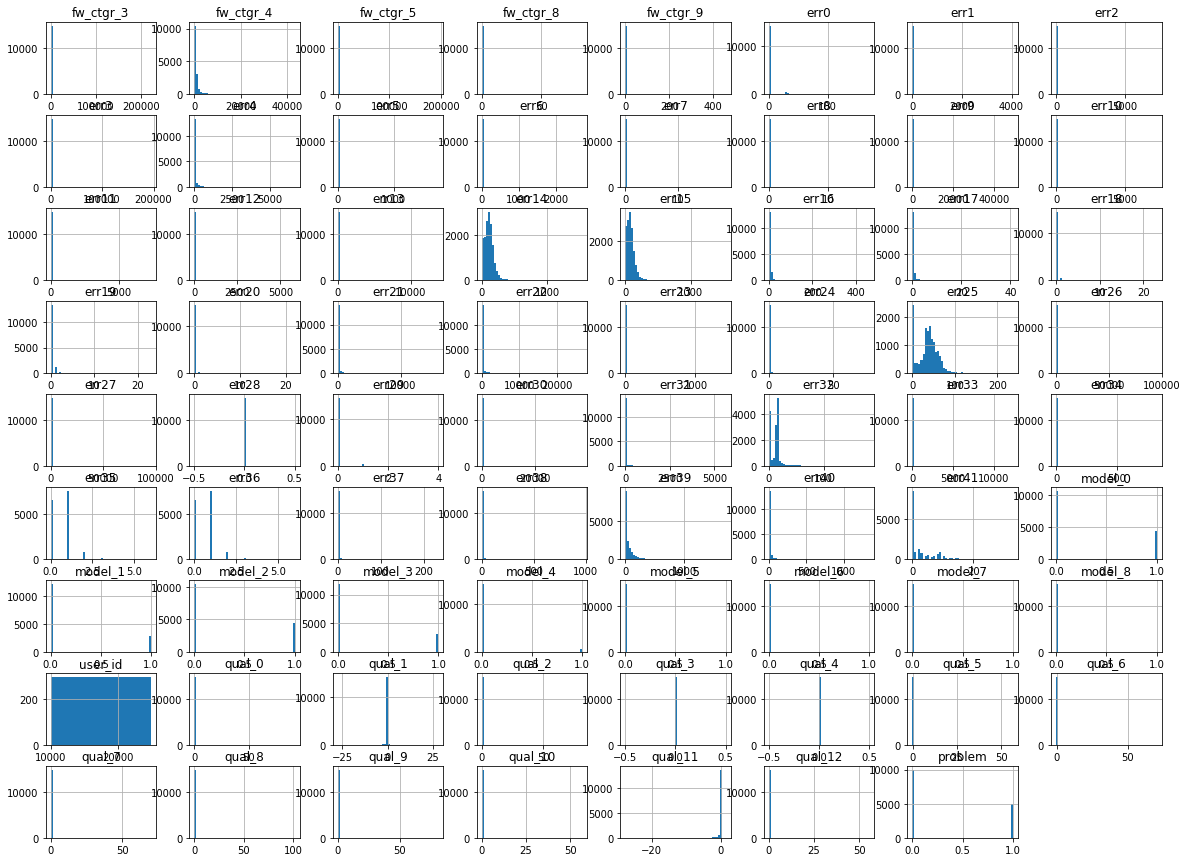

In [15]:
df.hist(bins=50, figsize=(20, 15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce8a728b00>,
      dtype=object)

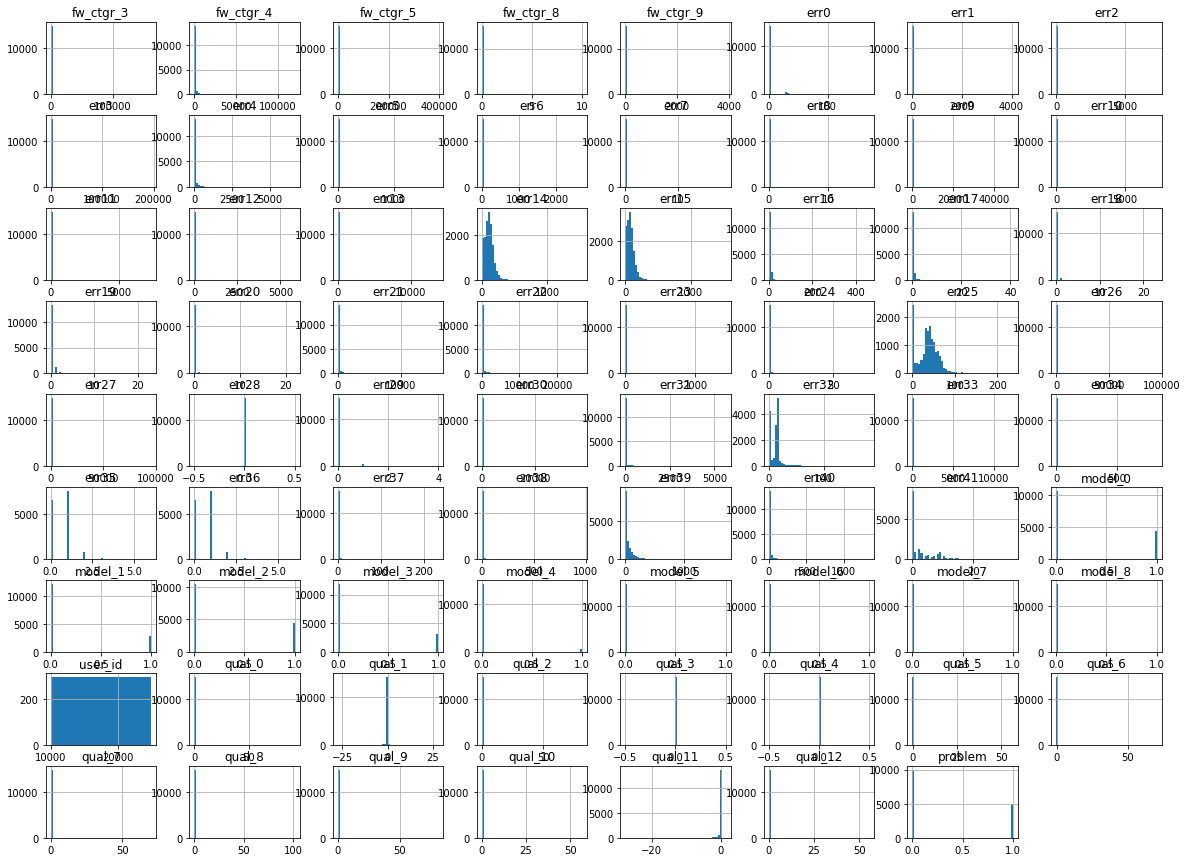

In [16]:
df_2.hist(bins=50, figsize=(20, 15))

In [ ]:
########################################
########################################
########################################

In [17]:
train_prob = pd.read_csv(PATH+'train_problem_data.csv')
problem = np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0

problem[train_prob.user_id.unique()-10000] = 1 
# problem.shape

df['problem'] = problem

In [ ]:
########################################
########################################
########################################

In [23]:
# HDLY 0129

df.drop(['user_id'], axis=1, inplace=True)

In [24]:
# AutoML

clf2 = setup(data = df, target = 'problem') 

,Description,Value
0,session_id,3181
1,Target,problem
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(15000, 70)"
5,Missing Values,False
6,Numeric Features,60
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
########################################
########################################
########################################

In [25]:
best_3 = compare_models(sort = 'Accuracy', n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7946,0.8149,0.5080,0.7987,0.6209,0.4895,0.5131,12.966
lightgbm,Light Gradient Boosting Machine,0.7899,0.8122,0.5152,0.7758,0.6189,0.4820,0.5014,0.375
gbc,Gradient Boosting Classifier,0.7880,0.8119,0.4787,0.8017,0.5992,0.4674,0.4962,2.969
et,Extra Trees Classifier,0.7846,0.8023,0.4957,0.7737,0.6040,0.4657,0.4876,1.682
rf,Random Forest Classifier,0.7825,0.8026,0.4836,0.7762,0.5957,0.4578,0.4819,2.189
xgboost,Extreme Gradient Boosting,0.7814,0.7978,0.5379,0.7313,0.6197,0.4714,0.4824,5.592
ada,Ada Boost Classifier,0.7757,0.7944,0.4713,0.7609,0.5818,0.4400,0.4637,0.712
lda,Linear Discriminant Analysis,0.7668,0.7586,0.3667,0.8398,0.5100,0.3867,0.4440,0.120
ridge,Ridge Classifier,0.7658,0.0000,0.3598,0.8447,0.5041,0.3820,0.4418,0.038
lr,Logistic Regression,0.7366,0.7526,0.3129,0.7448,0.4404,0.3040,0.3530,1.785


In [26]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7943,0.8282,0.4928,0.8128,0.6136,0.4847,0.5128
1,0.7943,0.8212,0.5201,0.7870,0.6263,0.4924,0.5125
2,0.7976,0.8093,0.4971,0.8219,0.6195,0.4928,0.5217
3,0.7829,0.8079,0.4842,0.7765,0.5965,0.4586,0.4826
4,0.7913,0.8044,0.4971,0.7972,0.6124,0.4799,0.5050
Mean,0.7921,0.8142,0.4983,0.7991,0.6137,0.4817,0.5069
SD,0.0050,0.0090,0.0119,0.0165,0.0099,0.0125,0.0133


In [27]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7889,0.8181,0.4993,0.8006,0.6151,0.4802,0.5056


In [28]:
final_model = finalize_model(blended)

In [ ]:
# plt.figure(figsize=(45,45))
# sns.heatmap(data = df.corr(), annot=True, 
# fmt = '.2f', linewidths=.5, cmap='Blues')

In [ ]:
########################################
########################################
########################################

In [29]:
df_corr = df.corr()

t_list = list(df_corr.index)
t_list = t_list[:-1]
# t_list

In [30]:
# 변수 이름 변경 : error  -> train_x / problem-> train_y

# train_x = df.to_numpy()
# train_x = df[t_list].to_numpy() # 0129, MH edited  this part
df.drop(['problem'], axis=1, inplace=True)
train_x = df.to_numpy()

train_y = problem

# del error, problem
print(train_x.shape)
print(train_y.shape)

(15000, 69)
(15000,)


In [ ]:
########################################
########################################
########################################

In [31]:
# Train

#-------------------------------------------------------------------------------------

# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True

#-------------------------------------------------------------------------------------

models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5

lr = 0.01 #learning_rate
nbr = 20000 #num_boost_round 
vb = 500 #verbose_eval
esr = 2000 #early_stopping_rounds
boosting_type = ['gbdt','dart']

# 파라미터 설정
params =      {
                'boosting_type' : boosting_type[1],
                'objective'     : 'binary',
                'metric'        : 'auc',
                'learning_rate' : lr,
                'seed': 2021
                }

es_only_dart = [8000, 12000, 5500, 10500]
es_only_index = 0

#-------------------------------------------------------------------------------------

# 5 Kfold cross validation
k_fold = KFold(n_splits=4, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x[train_idx]
    y = train_y[train_idx]
    valid_x = train_x[val_idx]
    valid_y = train_y[val_idx]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)
    
    #run traning
    model = lgb.train(
                        params,
                        train_set       = d_train,
                        # num_boost_round = nbr,
                        num_boost_round = es_only_dart[es_only_index],
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = vb, 
                        early_stopping_rounds = esr
                       )
    
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')
    es_only_index += 1


print(f"RESULT AUC : {np.mean(auc_scores)}")

[LightGBM] [Info] Number of positive: 3610, number of negative: 7640
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6596
[LightGBM] [Info] Number of data points in the train set: 11250, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.320889 -> initscore=-0.749690
[LightGBM] [Info] Start training from score -0.749690
[500]	valid_0's auc: 0.796204	valid_0's pr_auc: 0.741922
[1000]	valid_0's auc: 0.806955	valid_0's pr_auc: 0.753334
[1500]	valid_0's auc: 0.809363	valid_0's pr_auc: 0.753979
[2000]	valid_0's auc: 0.810102	valid_0's pr_auc: 0.756047
[2500]	valid_0's auc: 0.810951	valid_0's pr_auc: 0.75796
[3000]	valid_0's auc: 0.811212	valid_0's pr_auc: 0.758523
[3500]	valid_0's auc: 0.809901	valid_0's pr_auc: 0.757228
[4000]	valid_0's auc: 0.808507	valid_

In [ ]:
########################################
########################################
########################################

In [ ]:
# test_err  = pd.read_csv(PATH+'test_err_data.csv')

In [32]:
# 예측

df_2.drop(['user_id','problem'], axis=1, inplace=True) # 0129, MH added this part
pred_y_list = []

for model in models:
    # pred_y = model.predict(test_x)
    pred_y = model.predict(df_2[t_list].to_numpy())
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

pred_ensemble

array([[0.13998321],
       [0.92933883],
       [0.25497855],
       ...,
       [0.00828403],
       [0.59410974],
       [0.40110381]])

In [33]:
# HDLY

# 제출

sample_submssion = pd.read_csv(PATH+'sample_submission.csv')
sample_submssion['problem'] = pred_ensemble.reshape(-1)

sample_submssion.to_csv("HDLY_0129.csv", index = False)
sample_submssion

,user_id,problem
0,30000,0.139983
1,30001,0.929339
2,30002,0.254979
3,30003,0.096111
4,30004,0.436827
...,...,...
14994,44994,0.183067
14995,44995,0.109072
14996,44996,0.008284
14997,44997,0.594110


In [ ]:
########################################
########################################
########################################

In [ ]:
########################################
########################################
########################################

In [ ]:
########################################
########################################
########################################

In [ ]:
########################################
########################################
########################################
########################################
########################################
########################################
########################################
########################################
########################################
########################################
########################################
########################################
########################################
########################################
########################################
########################################
########################################
########################################

In [ ]:
data_mh_test = pd.read_csv(PATH+"0127_KMH_test_data_merge_2.csv")
data_mh_test.head()

,err0,err1,err2,err3,err4,err5,err6,err7,err8,err9,err10,err11,err12,err13,err14,err15,err16,err17,err18,err19,err20,err21,err22,err23,err24,err25,err26,err27,err28,err29,err30,err31,err32,err33,err34,err35,err36,err37,err38,err39,...,04.22.1778,04.33.1095,04.33.1125,04.33.1149,04.33.1171,04.33.1185,04.33.1261,04.73.2237,04.73.2569,04.73.2571,04.73.2577,04.82.1684,04.82.1730,04.82.1778,05.15.2090,05.15.2092,05.15.2114,05.15.2120,05.15.2122,05.15.2138,05.15.3104,05.66.3237,05.66.3571,10,10.22.1770,10.22.1780,8.5.3,qual_0,qual_1,qual_2,qual_3,qual_4,qual_5,qual_6,qual_7,qual_8,qual_9,qual_10,qual_11,qual_12
0,0.0,0.0,0.0,0.0,62.0,1.0,1.0,0.0,0.0,0.0,16.0,16.0,0.0,3.0,67.0,37.0,9.0,3.0,0.0,1.0,0.0,983.0,1308.0,5.0,2.0,32.0,0.0,0.0,0.0,0.0,83.0,2.0,16.0,0.0,1.0,3.0,3.0,0.0,2.0,92.0,...,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,60.0,0.0,0.0,24.0,0.0,0.0
1,0.0,0.0,3.0,98.0,3.0,4.0,4.0,0.0,0.0,0.0,12.0,16.0,4.0,6.0,53.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.0,9.0,-9.0,0.0,0.0,2572.0,-9.0,0.0,0.0,0.0,30756.0,-9.0,0.0
2,0.0,0.0,0.0,0.0,79.0,2.0,1.0,0.0,0.0,0.0,16.0,16.0,0.0,1.0,173.0,133.0,0.0,0.0,0.0,0.0,0.0,60.0,40.0,2.0,0.0,40.0,0.0,0.0,0.0,0.0,230.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,14.0,113.0,...,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-15.0,15.0,-15.0,0.0,0.0,148.0,-15.0,0.0,0.0,0.0,1596.0,-15.0,0.0
3,0.0,0.0,0.0,0.0,107.0,2.0,2.0,0.0,0.0,0.0,4.0,5.0,1.0,7.0,8.0,12.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,0.0,0.0,5.0,2.0,2.0,0.0,0.0,134.0,0.0,4.0,16.0,3.0,1.0,1.0,0.0,0.0,40.0,...,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,220.0,2640.0,0.0,0.0,144.0,0.0,0.0
4,0.0,0.0,0.0,2.0,6.0,1.0,1.0,0.0,0.0,0.0,10.0,12.0,1.0,18.0,80.0,67.0,6.0,0.0,0.0,0.0,0.0,10.0,8.0,0.0,0.0,14.0,1.0,1.0,0.0,0.0,332.0,152.0,11.0,6.0,1.0,1.0,1.0,1.0,0.0,48.0,...,0.0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,6.0,-6.0,0.0,0.0,8.0,27.0,396.0,0.0,0.0,24.0,-6.0,0.0


In [ ]:
drop_columns = data_mh_train.iloc[:, 51:98].columns[1:]
# drop_columns
data_mh_train = data_mh_train.drop(columns=drop_columns, axis=1)
data_mh_train

,err0,err1,err2,err3,err4,err5,err6,err7,err8,err9,err10,err11,err12,err13,err14,err15,err16,err17,err18,err19,err20,err21,err22,err23,err24,err25,err26,err27,err28,err29,err30,err31,err32,err33,err34,err35,err36,err37,err38,err39,err40,err41,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,user_id,qual_0,qual_1,qual_2,qual_3,qual_4,qual_5,qual_6,qual_7,qual_8,qual_9,qual_10,qual_11,qual_12,problem
0,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,15.0,16.0,1.0,10.0,59.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10000,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,144.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,10.0,11.0,1.0,15.0,151.0,128.0,0.0,4.0,1.0,3.0,1.0,756.0,751.0,5.0,1.0,22.0,0.0,0.0,0.0,0.0,250.0,0.0,10.0,18.0,0.0,1.0,1.0,0.0,0.0,113.0,56.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,13.0,14.0,1.0,4.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,25.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10002,0.0,-2.0,-1.0,0.0,0.0,33.0,44.0,552.0,0.0,12.0,372.0,-2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,52.0,30.0,1.0,0.0,0.0,0.0,0.0,28.0,19.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,65.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0,0.0,17.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,16.0,19.0,3.0,5.0,143.0,91.0,0.0,0.0,0.0,0.0,0.0,140.0,119.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,176.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10004,-2.0,-2.0,-2.0,0.0,0.0,6.0,85.0,1044.0,0.0,0.0,48.0,-2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,0.0,5.0,10.0,8.0,8.0,26.0,18.0,0.0,0.0,0.0,0.0,0.0,17.0,12.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,31.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,7.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,24995,-10.0,-10.0,-10.0,0.0,0.0,15.0,-10.0,0.0,0.0,0.0,60.0,-10.0,0.0,0.0
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,24996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,16.0,18.0,4.0,1.0,181.0,138.0,0.0,0.0,0.0,0.0,0.0,50.0,29.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,223.0,0.0,16.0,17.0,0.0,1.0,1.0,0.0,0.0,58.0,8.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24997,-4.0,-4.0,-4.0,0.0,0.0,23.0,-4.0,0.0,0.0,0.0,228.0,-4.0,0.0,1.0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,0.0,1.0,51.0,12.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,14.0,0.0,15.0,12.0,0.0,1.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
data_mh_test.iloc[:10, 50:60]

,model_8,03.11.1141,03.11.1149,03.11.1167,04.16.2641,04.16.3345,04.16.3439,04.16.3553,04.16.3569,04.16.3571
0,0.0,0.0,0.0,0.0,0,0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0,0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0,0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,1.0,0,0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0


In [ ]:
########################################
########################################
########################################

In [ ]:
# # 데이터 설명을 확인하면
# # ueser_id가 10000부터 24999까지 총 15000개가 연속적으로 존재.
# display(train_err.head())
# train_user_id_max = 24999
# train_user_id_min = 10000
# train_user_number = 15000

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [ ]:
# print(np.sort(train_err.errtype.unique()))
# # errtype이 1부터 42까지 29를 제외한 41개가 존재.

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42]


In [ ]:
# user_id와 errtype만을 사용하여 데이터 셋 생성
# 모든 일자에 대해서 errtype별 발생 건수를 count
# pandas의 groupby를 활용할 경우 큰 연산 자원이 필요.
# numpy로 placeholder를 만들어 구현함.

id_error = train_err[['user_id','errtype']].values
error = np.zeros((train_user_number,42))

for person_idx, err in tqdm(id_error):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - train_user_id_min,err - 1] += 1
error.shape

100%|██████████| 16554663/16554663 [00:47<00:00, 351720.70it/s]


(15000, 42)

In [ ]:
# HDLY

# train_err 시간 구하기

train_err             = pd.read_csv(PATH+'train_err_data.csv')
train_err['datetime'] = train_err['time'].apply(make_datetime)

min_day = train_err.datetime.min().date()
print(min_day)

train_err['days'] = train_err.loc[:,'datetime'].dt.date - min_day
train_err['days'] = train_err['days'].dt.days

train_err['hour'] = train_err.loc[:, 'datetime'].dt.time

display(train_err)

2020-10-31


,user_id,time,model_nm,fwver,errtype,errcode,datetime,days,hour
0,10000,20201101025616,model_3,05.15.2138,15,1,2020-11-01 02:00:00,1,02:00:00
1,10000,20201101030309,model_3,05.15.2138,12,1,2020-11-01 03:00:00,1,03:00:00
2,10000,20201101030309,model_3,05.15.2138,11,1,2020-11-01 03:00:00,1,03:00:00
3,10000,20201101050514,model_3,05.15.2138,16,1,2020-11-01 05:00:00,1,05:00:00
4,10000,20201101050515,model_3,05.15.2138,4,0,2020-11-01 05:00:00,1,05:00:00
...,...,...,...,...,...,...,...,...,...
16554658,24999,20201130163051,model_3,05.15.2138,15,1,2020-11-30 16:00:00,30,16:00:00
16554659,24999,20201130172625,model_3,05.15.2138,16,1,2020-11-30 17:00:00,30,17:00:00
16554660,24999,20201130172625,model_3,05.15.2138,4,0,2020-11-30 17:00:00,30,17:00:00
16554661,24999,20201130172631,model_3,05.15.2138,4,0,2020-11-30 17:00:00,30,17:00:00


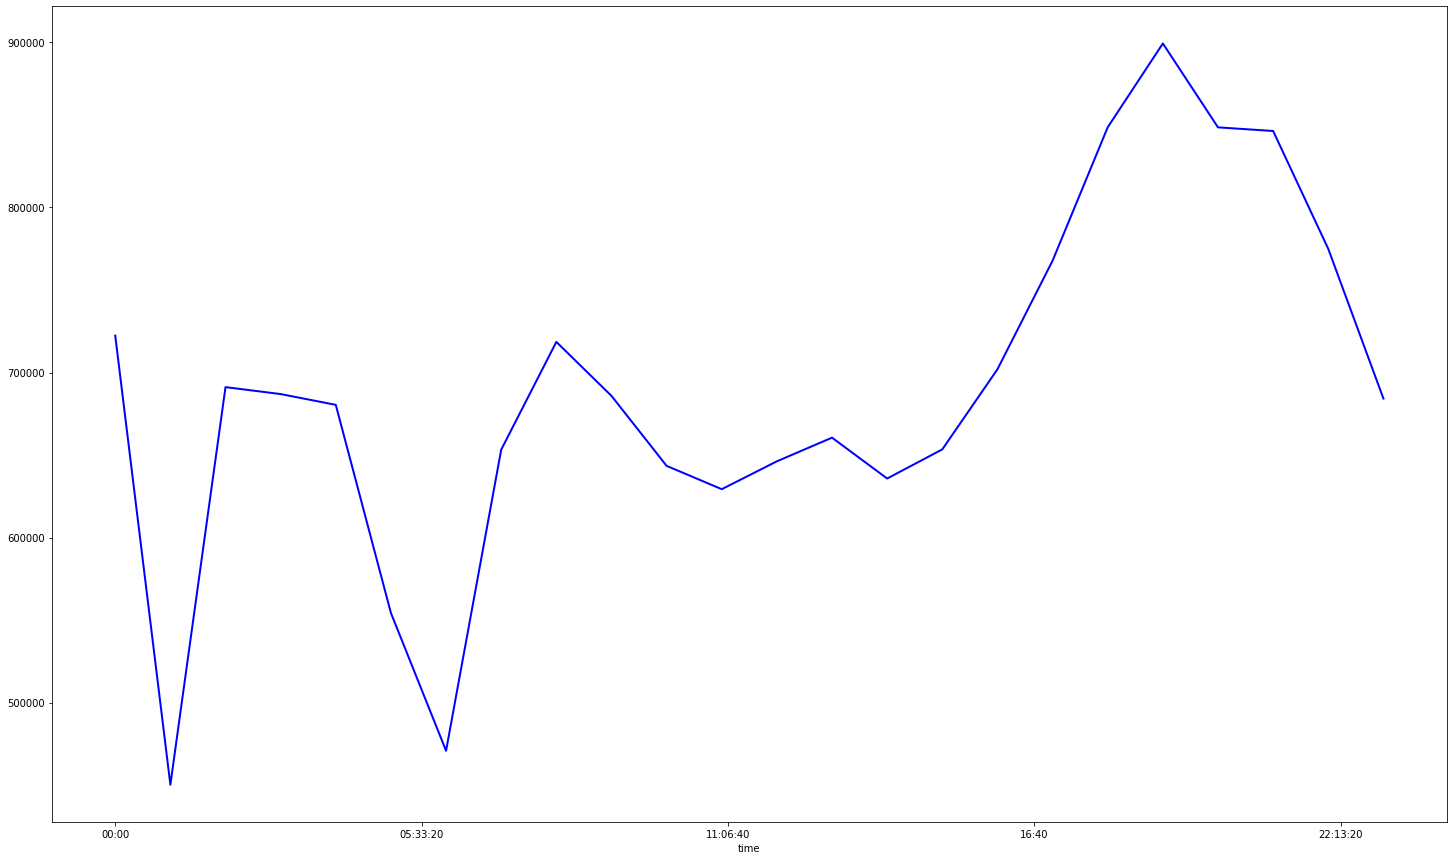

In [ ]:
#  Train_err_data의 hour 분포 확인

#train_err[col].value_counts().sort_index() # 시간 별 err 수 카운트
train_err['hour'].value_counts().sort_index().plot(color='b', lw=2, label='train', figsize=(25, 15))
# train_err['time'].value_counts().sort_index().plot(color='r',  lw=2, label='test')

# fig = plt.figure(figsize=(20, 20))
# plt.legend()
# plt.xlabel("hour")
# plt.ylabel("# of rows")
# plt.title("Distribution of date in Train/Test-Quality");

In [ ]:
# HDLY

# problem 시간 구하기

train_problem             = pd.read_csv(PATH+'train_problem_data.csv')
train_problem['datetime'] = train_problem['time'].apply(make_datetime)

min_day = train_problem.datetime.min().date()

train_problem['days'] = train_problem.loc[:,'datetime'].dt.date - min_day
train_problem['days'] = train_problem['days'].dt.days + 1 # problem 데이터에는 10/31일이 없기 때문에  err&quality 데이터랑 규격을 맞춰주기 위해 1을 더함

train_problem['hour'] = train_problem.loc[:, 'datetime'].dt.time

display(train_problem)

,user_id,time,datetime,days,hour
0,19224,20201102200000,2020-11-02 20:00:00,2,20:00:00
1,23664,20201116140000,2020-11-16 14:00:00,16,14:00:00
2,15166,20201114130000,2020-11-14 13:00:00,14,13:00:00
3,12590,20201108210000,2020-11-08 21:00:00,8,21:00:00
4,15932,20201103210000,2020-11-03 21:00:00,3,21:00:00
...,...,...,...,...,...
5424,20167,20201125120000,2020-11-25 12:00:00,25,12:00:00
5425,16270,20201110120000,2020-11-10 12:00:00,10,12:00:00
5426,19114,20201106230000,2020-11-06 23:00:00,6,23:00:00
5427,21505,20201104110000,2020-11-04 11:00:00,4,11:00:00


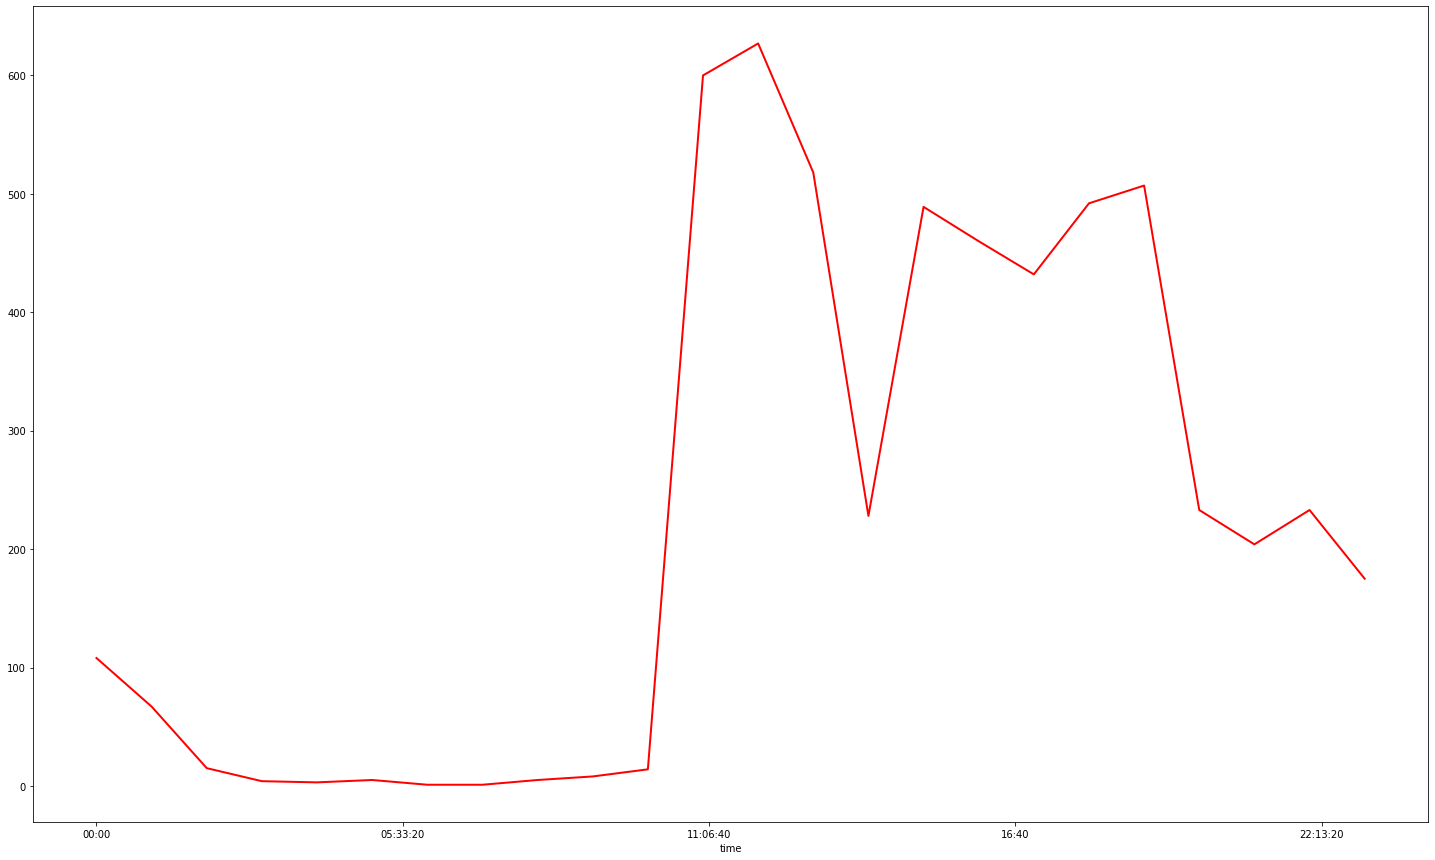

In [ ]:
#  train_problem_data hour 분포 확인

train_problem['hour'].value_counts().sort_index().plot(color='r', lw=2, label='train', figsize=(25, 15))

In [ ]:
# HDLY

# quality 시간 구하기

train_quality             = pd.read_csv(PATH+'train_quality_data.csv')
train_quality['datetime'] = train_quality['time'].apply(make_datetime)

min_day = train_quality.datetime.min().date()

train_quality['days'] = train_quality.loc[:,'datetime'].dt.date - min_day
train_quality['days'] = train_quality['days'].dt.days

train_quality['hour'] = train_quality.loc[:, 'datetime'].dt.time

display(train_quality)

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,datetime,days,hour
0,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,2020-11-29 09:00:00,29,09:00:00
1,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,2020-11-29 09:00:00,29,09:00:00
2,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,2020-11-29 09:00:00,29,09:00:00
3,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,2020-11-29 09:00:00,29,09:00:00
4,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,2020-11-29 09:00:00,29,09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,1,0,0,0,0,17,0,0,2020-11-24 03:00:00,24,03:00:00
828620,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0,2020-11-24 03:00:00,24,03:00:00
828621,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,3,0,0,0,0,17,0,0,2020-11-24 03:00:00,24,03:00:00
828622,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0,2020-11-24 03:00:00,24,03:00:00


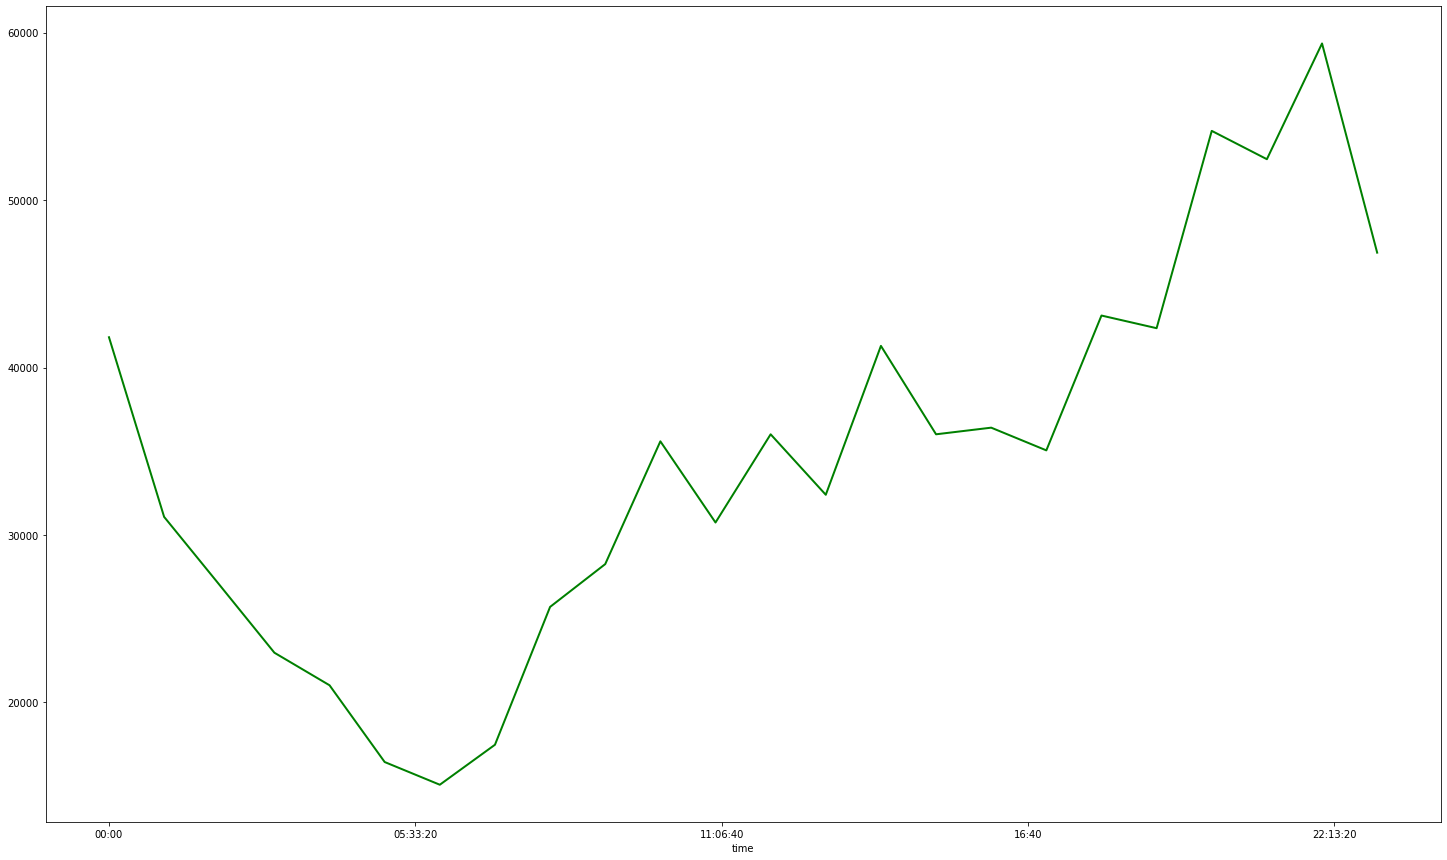

In [ ]:
#  train_problem_data hour 분포 확인

train_quality['hour'].value_counts().sort_index().plot(color='g', lw=2, label='train', figsize=(25, 15))

In [ ]:
train_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 19 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        828624 non-null  int64         
 1   user_id     828624 non-null  int64         
 2   fwver       788544 non-null  object        
 3   quality_0   684192 non-null  float64       
 4   quality_1   828624 non-null  int64         
 5   quality_2   788511 non-null  float64       
 6   quality_3   828624 non-null  int64         
 7   quality_4   828624 non-null  int64         
 8   quality_5   828604 non-null  object        
 9   quality_6   828624 non-null  int64         
 10  quality_7   828624 non-null  object        
 11  quality_8   828624 non-null  object        
 12  quality_9   828624 non-null  object        
 13  quality_10  828624 non-null  object        
 14  quality_11  828624 non-null  int64         
 15  quality_12  828624 non-null  int64         
 16  da

In [ ]:
# HDLY

# qualit data 값들 중에서 object를 int형으로 모두 변환

obj_quality = [5, 7, 8, 9, 10] # 얘네만 object형, 나머지는 int/float형

for i in obj_quality : 
    col_name = 'quality_'+str(i)
    train_quality[col_name] = train_quality[col_name].apply(string2num)

train_quality

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,datetime,days,hour
0,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,2020-11-29 09:00:00,29,09:00:00
1,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,2020-11-29 09:00:00,29,09:00:00
2,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,2020-11-29 09:00:00,29,09:00:00
3,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,2020-11-29 09:00:00,29,09:00:00
4,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,2020-11-29 09:00:00,29,09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,1,0,0,0,0,17,0,0,2020-11-24 03:00:00,24,03:00:00
828620,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0,2020-11-24 03:00:00,24,03:00:00
828621,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,3,0,0,0,0,17,0,0,2020-11-24 03:00:00,24,03:00:00
828622,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0,2020-11-24 03:00:00,24,03:00:00


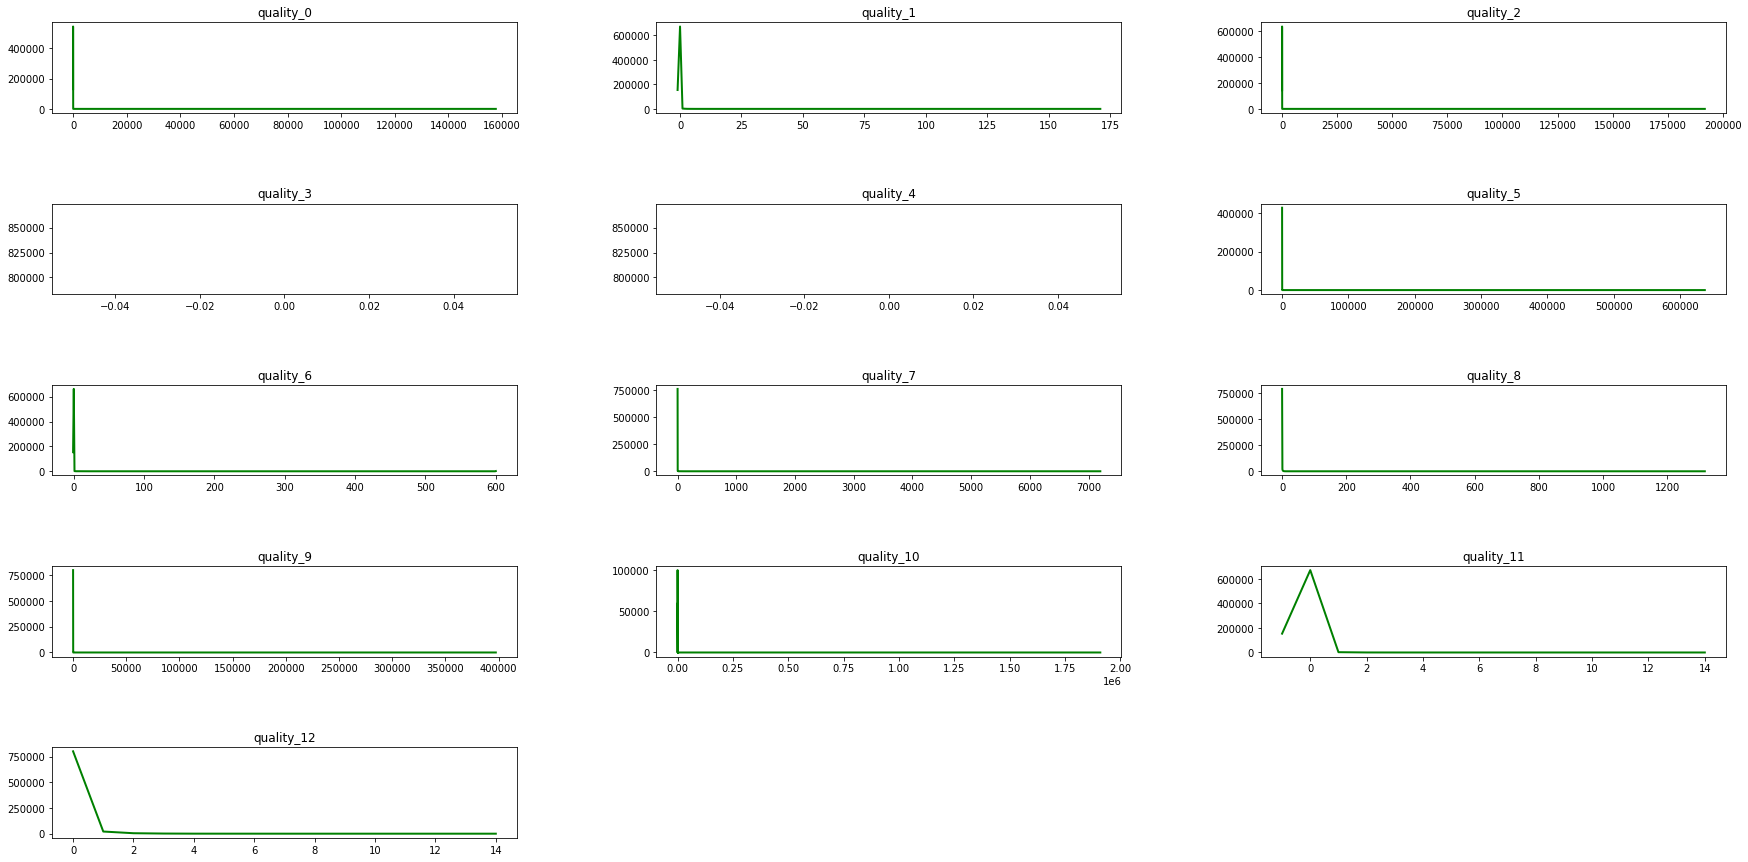

In [ ]:
# HDLY

# quality data 각각마다 time 별  분포

fig = plt.figure(figsize=(30, 15))
num_of_quality = 13 # 0~12, 총 13개

for i in range(num_of_quality) : 
  ax = fig.add_subplot(5, 3, i+1)

  col_name = 'quality_'+str(i)
  ax.set_title(col_name)

  train_quality[col_name].value_counts().sort_index().plot(color='g', lw=2)

plt.subplots_adjust(hspace=1, wspace=0.3)
#  train_problem_data hour 분포 확인
# train_quality['hour'].value_counts().sort_index().plot(color='g', lw=2, label='train')

In [ ]:
train_err.loc[:, 'days']

0            1
1            1
2            1
3            1
4            1
            ..
16554658    30
16554659    30
16554660    30
16554661    30
16554662    30
Name: days, Length: 16554663, dtype: int64

In [ ]:
train_err.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16554663 entries, 0 to 16554662
Data columns (total 9 columns):
 #   Column    Dtype         
---  ------    -----         
 0   user_id   int64         
 1   time      int64         
 2   model_nm  object        
 3   fwver     object        
 4   errtype   int64         
 5   errcode   object        
 6   datetime  datetime64[ns]
 7   days      int64         
 8   hour      object        
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 1.1+ GB


In [ ]:
print(train_err['days'].min())
print(train_problem['days'].min())
print(train_quality['days'].min())

0
1
0


In [ ]:
print(train_quality['days'])
print(train_quality['days'].min())
print(train_quality['days'].max())

0         29
1         29
2         29
3         29
4         29
          ..
828619    24
828620    24
828621    24
828622    24
828623    24
Name: days, Length: 828624, dtype: int64
0
30


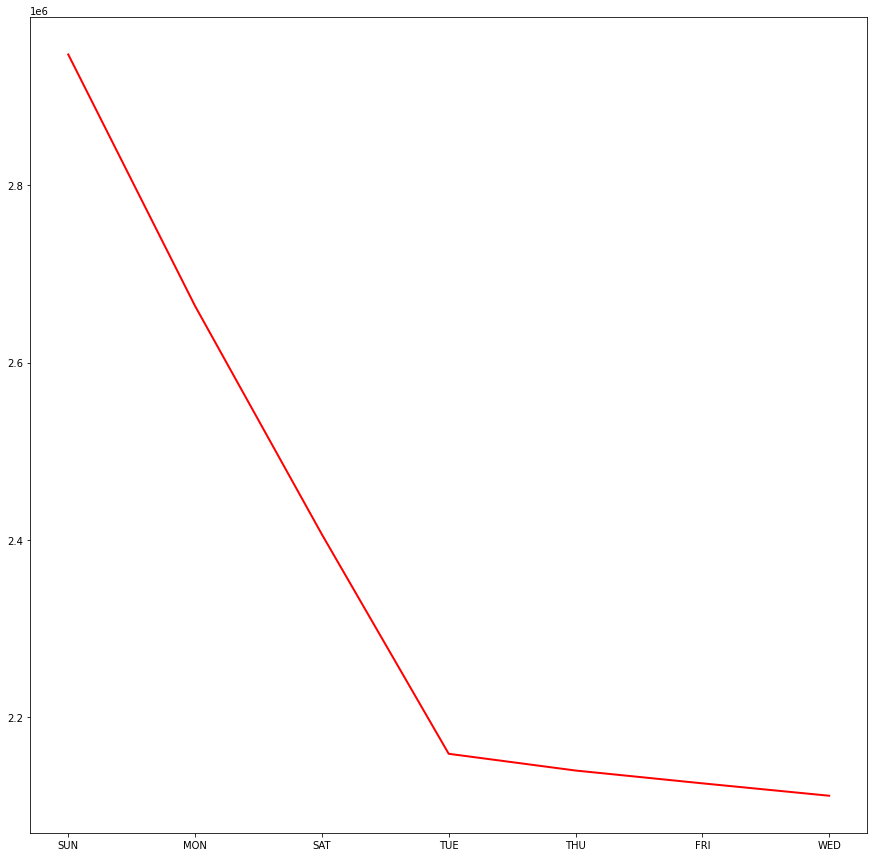

In [ ]:
# HDLY

# 요일 별 체크 확인

# 각 data에서 요일 구하고
train_err['d'] = train_err['days'].apply(days2d)
train_problem['d'] = train_problem['days'].apply(days2d)
train_quality['d'] = train_quality['days'].apply(days2d)

# 요일 별 데이터 양 분포 그래프로 확인
train_err['d'].value_counts().plot(color='r', lw=2, label='err', figsize=(15, 15))

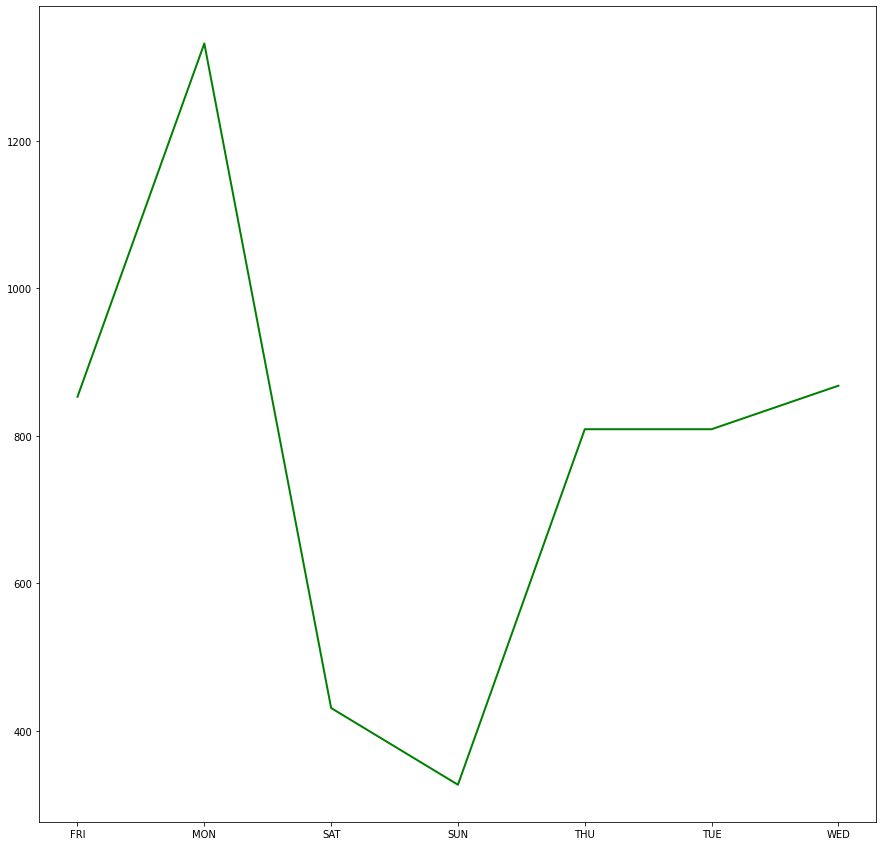

In [ ]:
train_problem['d'].value_counts().sort_index().plot(color='g', lw=2, label='problem', figsize=(15, 15))

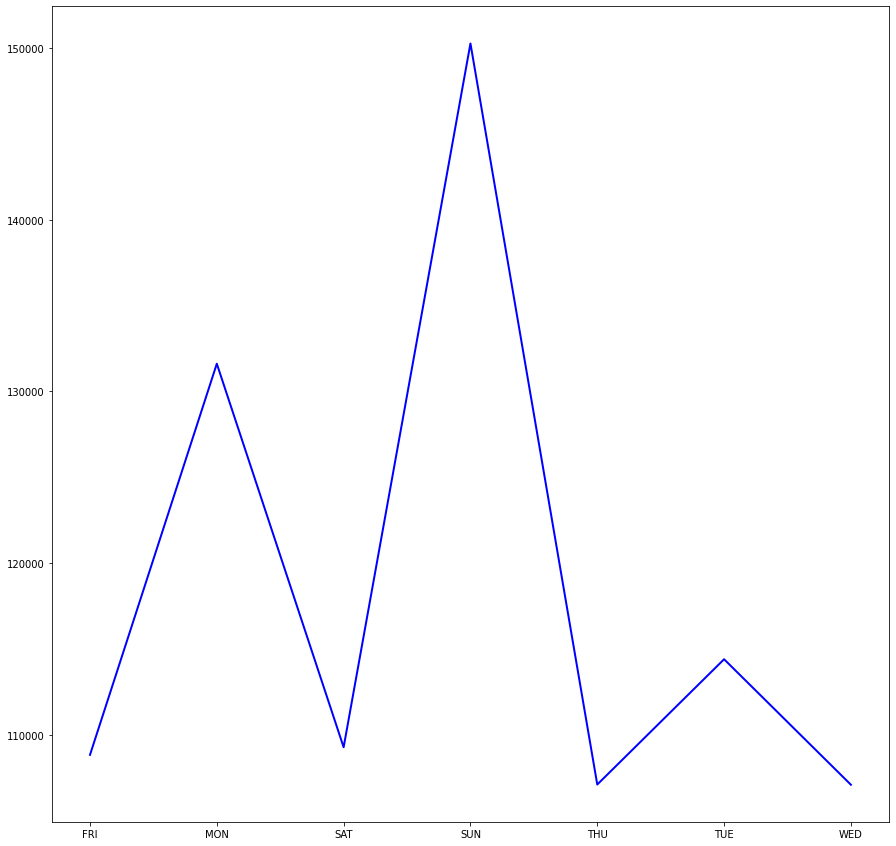

In [ ]:
train_quality['d'].value_counts().sort_index().plot(color='b', lw=2, label='quality', figsize=(15, 15))

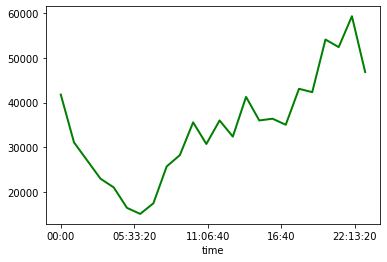

In [ ]:
train_quality['hour'].value_counts().sort_index().plot(color='g', lw=2, label='train')

In [ ]:
# HDLY

# qualit data 들의 값 분포 확인
for i in range(13) : 
  q_num = 'quality_' + str(i)
  q_unique = len(train_quality[q_num].unique())
  q_min = train_quality[q_num].min()
  q_max = train_quality[q_num].max()
  print(i, " ---- ", q_unique, " ---- ", q_min, " ---- ", q_max)

0  ----  754  ----  -1.0  ----  157667.0
1  ----  31  ----  -1  ----  171
2  ----  799  ----  -1.0  ----  191859.0
3  ----  1  ----  0  ----  0
4  ----  1  ----  0  ----  0
5  ----  4743  ----  0  ----  637385
6  ----  549  ----  -1  ----  600
7  ----  884  ----  0  ----  7200
8  ----  42  ----  0  ----  1317
9  ----  523  ----  0  ----  397424
10  ----  4200  ----  0  ----  1910175
11  ----  12  ----  -1  ----  14
12  ----  14  ----  0  ----  14


In [ ]:
train_quality.iloc[:, 3:16]

,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11
0,0.0,0,0.0,0,0,0,0,0,0,0,4,0
1,0.0,0,0.0,0,0,0,0,0,0,0,4,0
2,0.0,0,0.0,0,0,0,0,0,0,0,4,0
3,0.0,0,0.0,0,0,0,0,0,0,0,4,0
4,0.0,0,0.0,0,0,0,0,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
828619,0.0,0,0.0,0,0,1,0,0,0,0,17,0
828620,0.0,0,0.0,0,0,0,0,0,0,0,17,0
828621,0.0,0,0.0,0,0,3,0,0,0,0,17,0
828622,0.0,0,0.0,0,0,0,0,0,0,0,17,0


In [ ]:
# HDLY

# qualit data 들의 값 정규화, min-max 방식

qualities = train_quality.iloc[:, 3:16]

min_max_norm = MinMaxScaler()

for i in range(13) : 
  q_num = 'quality_' + str(i)
  normalized = min_max_norm.fit_transform(qualities)
  qualities = pd.DataFrame(normalized, columns=qualities.columns)

qualities

,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,0.000006,0.005814,0.000005,0.0,0.0,0.000000,0.001664,0.0,0.0,0.0,0.000002,0.066667,0.0
1,0.000006,0.005814,0.000005,0.0,0.0,0.000000,0.001664,0.0,0.0,0.0,0.000002,0.066667,0.0
2,0.000006,0.005814,0.000005,0.0,0.0,0.000000,0.001664,0.0,0.0,0.0,0.000002,0.066667,0.0
3,0.000006,0.005814,0.000005,0.0,0.0,0.000000,0.001664,0.0,0.0,0.0,0.000002,0.066667,0.0
4,0.000006,0.005814,0.000005,0.0,0.0,0.000000,0.001664,0.0,0.0,0.0,0.000002,0.066667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,0.000006,0.005814,0.000005,0.0,0.0,0.000002,0.001664,0.0,0.0,0.0,0.000009,0.066667,0.0
828620,0.000006,0.005814,0.000005,0.0,0.0,0.000000,0.001664,0.0,0.0,0.0,0.000009,0.066667,0.0
828621,0.000006,0.005814,0.000005,0.0,0.0,0.000005,0.001664,0.0,0.0,0.0,0.000009,0.066667,0.0
828622,0.000006,0.005814,0.000005,0.0,0.0,0.000000,0.001664,0.0,0.0,0.0,0.000009,0.066667,0.0


In [ ]:
train_quality.iloc[:, 3:16] = qualities

train_quality

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,datetime,days,hour
0,20201129090000,10000,05.15.2138,0.000006,0.005814,0.000005,0.0,0.0,0.000000,0.001664,0.0,0.0,0.0,0.000002,0.066667,0.0,2020-11-29 09:00:00,29,09:00:00
1,20201129090000,10000,05.15.2138,0.000006,0.005814,0.000005,0.0,0.0,0.000000,0.001664,0.0,0.0,0.0,0.000002,0.066667,0.0,2020-11-29 09:00:00,29,09:00:00
2,20201129090000,10000,05.15.2138,0.000006,0.005814,0.000005,0.0,0.0,0.000000,0.001664,0.0,0.0,0.0,0.000002,0.066667,0.0,2020-11-29 09:00:00,29,09:00:00
3,20201129090000,10000,05.15.2138,0.000006,0.005814,0.000005,0.0,0.0,0.000000,0.001664,0.0,0.0,0.0,0.000002,0.066667,0.0,2020-11-29 09:00:00,29,09:00:00
4,20201129090000,10000,05.15.2138,0.000006,0.005814,0.000005,0.0,0.0,0.000000,0.001664,0.0,0.0,0.0,0.000002,0.066667,0.0,2020-11-29 09:00:00,29,09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,20201124033000,24997,04.22.1778,0.000006,0.005814,0.000005,0.0,0.0,0.000002,0.001664,0.0,0.0,0.0,0.000009,0.066667,0.0,2020-11-24 03:00:00,24,03:00:00
828620,20201124033000,24997,04.22.1778,0.000006,0.005814,0.000005,0.0,0.0,0.000000,0.001664,0.0,0.0,0.0,0.000009,0.066667,0.0,2020-11-24 03:00:00,24,03:00:00
828621,20201124033000,24997,04.22.1778,0.000006,0.005814,0.000005,0.0,0.0,0.000005,0.001664,0.0,0.0,0.0,0.000009,0.066667,0.0,2020-11-24 03:00:00,24,03:00:00
828622,20201124033000,24997,04.22.1778,0.000006,0.005814,0.000005,0.0,0.0,0.000000,0.001664,0.0,0.0,0.0,0.000009,0.066667,0.0,2020-11-24 03:00:00,24,03:00:00


In [ ]:
# MH, model code copy

# """
# model_nm 값에 따라 사용자를 구분할 수 없다.
# """
model_uni_list = train_err['model_nm'].unique()

total = 0

for uni in model_uni_list:
  model_num = train_err['model_nm'] == uni
  total_len = len(train_err[model_num])
  display(train_err[model_num])
  total += total_len

print(f"sum : {total}")

"""
fwver 값에 따라 사용자를 구분할 수 없다.
다른 fwver 값에 포함되어 있을 수도 있다.
"""

model_uni_list = train_err['fwver'].unique()

total = 0

for uni in model_uni_list:
  model_num = train_err['fwver'] == uni
  total_len = len(train_err[model_num])
  display(train_err[model_num])
  total += total_len

print(f"sum : {total}")

# """
# model_nm(str)을 숫자형으로 변환하는 코드
# """

# train data
train_err  = pd.read_csv(PATH+'train_err_data.csv')
train_err['model_int'] = 0
for i in tqdm(range(len(train_err))):
  tmp_val = train_err['model_nm'][i][-1]
  train_err['model_int'][i] = int(tmp_val)



# test data
test_err = pd.read_csv('/content/data/test_err_data.csv')
test_err['model_int'] = 0
for i in tqdm(range(len(test_err))):
  tmp_val = test_err['model_nm'][i][-1]
  test_err['model_int'][i] = int(tmp_val)

100%|██████████| 16554663/16554663 [26:41<00:00, 10337.83it/s]


FileNotFoundError: ignored

In [ ]:
# error.shape
id_error = train_err[['user_id','errtype','days']].values
error = np.zeros((train_user_number,42, 33))
for idx, err, days in tqdm(id_error):
    error[idx - train_user_id_min,err - 1, days] += 1
error.shape

# model_list.shape
id_model = train_err[['user_id','model_int']].values
model_list = np.zeros((train_user_number,9))
for person_idx, m_int in tqdm(id_model):
    model_list[person_idx - train_user_id_min , m_int ] += 1

# fwver_list.shape
id_fwver = train_err[['user_id','fwver_int']].values
fwver_list = np.zeros((train_user_number,37))
for person_idx, fw_int in tqdm(id_fwver):
    fwver_list[person_idx - train_user_id_min , fw_int ] += 1

# quality_list.shape
train_qual.drop(['time','fwver'], axis=1, inplace = True)
tmp_train_qual = train_qual.groupby('user_id').sum().reset_index()
tmp_col = list(train_qual.columns)
train_user_number = 15000
train_user_id_min = 10000
qual_list = tmp_train_qual[tmp_col].values
qual = np.zeros((train_user_number,13))
for q_data  in tqdm(qual_list):
  index_id = int(q_data[0] - train_user_id_min)
  qual[index_id] = q_data[1:]

In [ ]:
# 병합
tmp_df = pd.DataFrame(error.tolist()).add_prefix('err')
tmp_df2 = pd.DataFrame(model_list.tolist()).add_prefix('model_')
tmp_df3 = pd.DataFrame(fwver_list.tolist()).add_prefix('fwver_')
tmp_df4 = pd.DataFrame(qual.tolist()).add_prefix('qual_')

df = tmp_df.join(tmp_df2)
df = df.join(tmp_df3)
df = df.join(tmp_df4)
df = tmp_df.join(tmp_df4)

print(df)

array([[10000,    15,     1],
       [10000,    12,     1],
       [10000,    11,     1],
       ...,
       [24999,     4,    30],
       [24999,     4,    30],
       [24999,    15,    30]])

#### 2.2. problem

In [ ]:
train_prob = pd.read_csv(PATH+'train_problem_data.csv')
problem = np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0
problem[train_prob.user_id.unique()-10000] = 1 
problem.shape

(15000,)

## 3. Light-gbm 모델 훈련

In [ ]:
# 변수 이름 변경
# error  -> train_x
# problem-> train_y

train_x = error
train_y = problem
del error, problem
print(train_x.shape)
print(train_y.shape)

(15000, 42, 33)
(15000,)


In [ ]:
# Train

# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True

models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5

In [ ]:
# 파라미터 설정

# ref url. https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

params = {
                'boosting_type' : 'dart',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'seed': 1015
                }

In [ ]:
# 5 Kfold cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x[train_idx]
    y = train_y[train_idx]
    valid_x = train_x[val_idx]
    valid_y = train_y[val_idx]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)
    
    #run traning
    model = lgb.train(
                        params,
                        train_set       = d_train,
                        num_boost_round = 2000,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 200, 
                        early_stopping_rounds = 10
                       )
    
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')

## 4. 교차 검증 점수 확인

In [ ]:
print(np.mean(auc_scores))

NameError: ignored

## 5. 제출 파일 생성

# 새 섹션

In [ ]:
test_err  = pd.read_csv(PATH+'test_err_data.csv')
display(test_err.head())

,user_id,time,model_nm,fwver,errtype,errcode
0,30000,20201101030227,model_1,04.16.3553,31,1
1,30000,20201101030227,model_1,04.16.3553,33,2
2,30000,20201101030228,model_1,04.16.3553,15,1
3,30000,20201101030256,model_1,04.16.3553,22,1
4,30000,20201101030300,model_1,04.16.3553,11,1


In [ ]:
# 데이터 설명을 확인하면
# test 데이터는 ueser_id가 30000부터 44998까지 총 14999개가 존재.
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

In [ ]:
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((test_user_number,42))
for person_idx, err in tqdm(id_error):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    test_x[person_idx - test_user_id_min,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
print(test_x.shape)

100%|██████████| 16532648/16532648 [01:00<00:00, 272404.47it/s]

(14999, 42)


In [ ]:
# 예측
pred_y_list = []
for model in models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

pred_ensemble

array([[0.86304892],
       [0.24459052],
       [0.22640172],
       ...,
       [0.56576105],
       [0.76814615],
       [0.42601461]])

In [ ]:
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')

sample_submssion['problem'] = pred_ensemble.reshape(-1)

sample_submssion.to_csv("dacon_baseline.csv", index = False)
sample_submssion

,user_id,problem
0,30000,0.863049
1,30001,0.244591
2,30002,0.226402
3,30003,0.791338
4,30004,0.735666
...,...,...
14994,44994,0.223210
14995,44995,0.381821
14996,44996,0.565761
14997,44997,0.768146
